In [1]:
pip install numpy pandas matplotlib tensorflow yfinance


[*********************100%%**********************]  1 of 1 completed


Epoch 1/20
2759/2759 [==============================] - 102s 35ms/step - loss: 4.7570e-04
Epoch 2/20
2759/2759 [==============================] - 97s 35ms/step - loss: 2.3101e-04
Epoch 3/20
2759/2759 [==============================] - 94s 34ms/step - loss: 1.2736e-04
Epoch 4/20
2759/2759 [==============================] - 97s 35ms/step - loss: 1.0112e-04
Epoch 5/20
2759/2759 [==============================] - 95s 34ms/step - loss: 9.5053e-05
Epoch 6/20
2759/2759 [==============================] - 97s 35ms/step - loss: 9.1382e-05
Epoch 7/20
2759/2759 [==============================] - 95s 34ms/step - loss: 8.4664e-05
Epoch 8/20
2759/2759 [==============================] - 97s 35ms/step - loss: 1.0551e-04
Epoch 9/20
2759/2759 [==============================] - 96s 35ms/step - loss: 7.3012e-05
Epoch 10/20
2759/2759 [==============================] - 98s 36ms/step - loss: 7.5906e-05
Epoch 11/20
2759/2759 [==============================] - 96s 35ms/step - loss: 7.6225e-05
Epoch 12/20
2759/2

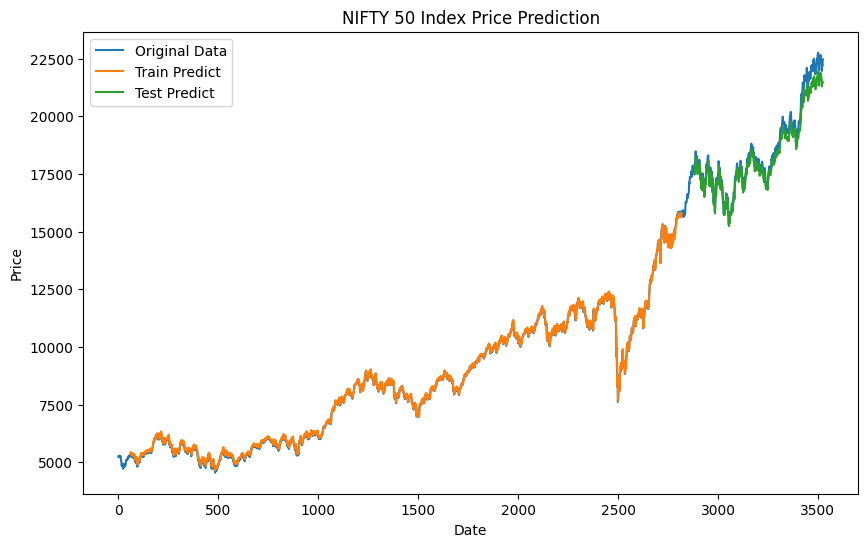

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

# Define the ticker symbol and the period
ticker_symbol = '^NSEI'
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Preprocess the data
data = data[['Close']].dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the training data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
early_stop = EarlyStopping(monitor='loss', patience=5)
model.fit(X_train, y_train, batch_size=1, epochs=20, callbacks=[early_stop])

# Predict and inverse transform the scaled data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE
train_rmse = np.sqrt(np.mean(((train_predict - scaler.inverse_transform([y_train])) ** 2)))
test_rmse = np.sqrt(np.mean(((test_predict - scaler.inverse_transform([y_test])) ** 2)))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Plot the results
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(train_plot, label='Train Predict')
plt.plot(test_plot, label='Test Predict')
plt.title('NIFTY 50 Index Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
